In [63]:
!pip install tensorflow
!pip install tensorflow-text

In [64]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [65]:
df=pd.read_excel('SMSSpamCollection.xlsx')
df = df.dropna(how = "any", axis = 1)

In [85]:
df.columns = ['label', 'body']

First, I create two data frames, one for each class, and see if they does not have the same number of samples (they are unbalanced). 

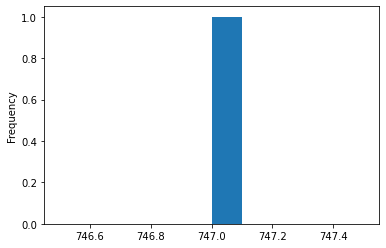

In [89]:
spam_df = df[df['label']=='spam']
spam_df['label'].value_counts().plot(kind = "hist") #747 samples

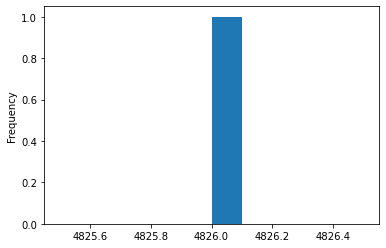

In [90]:
ham_df = df[df['label']=='ham']
ham_df['label'].value_counts().plot(kind = "hist") #4826 samples (they are unbalanced)

In [91]:
ham_df_balanced = ham_df.sample(spam_df.shape[0])
dfb = pd.concat([ham_df_balanced, spam_df])

In [92]:
dfb['label'].value_counts()

ham     747
spam    747
Name: label, dtype: int64

Now the dataset is balanced.

We will download two BERT models, one to perform preprocessing and the other one for encoding.

In [71]:
preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

We are going to use preprocess as the input for this layer. Then, the encoder is going to convert the preprocessed text in vectors (output of the layer). 

In [72]:
tinput = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
tpreprocess = preprocess(tinput)
tencoder = encoder(tpreprocess)

Finally, this output is going to be fed in the neural network layers, that are two, the Dropout layer, and the Dense layer.

In [73]:
layer = tf.keras.layers.Dropout(0.1, name="dropout")(tencoder['pooled_output'])
layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(layer)

We add the input and output layers to construct the final model

In [74]:
model = tf.keras.Model(inputs=[tinput], outputs = [layer])

We are going to compile the model 

In [75]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics =  tf.keras.metrics.BinaryAccuracy(name='accuracy')

model.compile(optimizer='adam',
 loss=loss,
 metrics=metrics)

Then we are going to fit the model. The model is going to learn from the samples of the training data, and identify patterns.

In [76]:
dfb['spam_or_ham'] = dfb['label'].apply(lambda x: 1 if x=='spam' else 0)
X_train, X_test, y_train, y_test = train_test_split(dfb['body'],dfb['spam_or_ham'], stratify=dfb['spam_or_ham'])
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 202s 6s/step - loss: 0.6754 - accuracy: 0.5813
Epoch 2/10
35/35 [==============================] - 212s 6s/step - loss: 0.5448 - accuracy: 0.7946
Epoch 3/10
35/35 [==============================] - 248s 7s/step - loss: 0.4546 - accuracy: 0.8616
Epoch 4/10
35/35 [==============================] - 215s 6s/step - loss: 0.4021 - accuracy: 0.8732
Epoch 5/10
35/35 [==============================] - 201s 6s/step - loss: 0.3733 - accuracy: 0.8884
Epoch 6/10
35/35 [==============================] - 196s 6s/step - loss: 0.3504 - accuracy: 0.8857
Epoch 7/10
35/35 [==============================] - 194s 6s/step - loss: 0.3314 - accuracy: 0.8973
Epoch 8/10
35/35 [==============================] - 198s 6s/step - loss: 0.3135 - accuracy: 0.9098
Epoch 9/10
35/35 [==============================] - 198s 6s/step - loss: 0.2941 - accuracy: 0.9125
Epoch 10/10
35/35 [==============================] - 214s 6s/step - loss: 0.2830 - accuracy: 0.9116


After training the model, we are going to predict and classify the samples in the testing dataset. We are going to get as an output an array of 0´s and 1´s, in which a 0 indicates that the message is ham and 1 if it is spam.

In [77]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,

Also, we can make predictions inserting ourselves a set of messages, obtaining as a result an array of numbers, in which a number above 0.5 indicated that the message is considered spam, and a number below 0.5 that is ham.

In [78]:
test_dataset = [
 'You can win a lot of money, register in the link below',
 'You have an iPhone 10, spin the image below to claim your prize and it will be delivered in your door step',
 'You have an offer, the company will give you 50% off on every item purchased.',
 'Hey Bravin, do not be late for the meeting tomorrow will start lot exactly 10:30 am',
 "See you monday, we have alot to talk about the future of this company ."
]

model.predict(test_dataset)

array([[0.6969731 ],
       [0.9157373 ],
       [0.53140694],
       [0.6665542 ],
       [0.15635076]], dtype=float32)